In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = "drive/MyDrive/pokemon-dataset-1000/dataset"
testset = "drive/MyDrive/pokemon-dataset-1000/test"


In [ ]:
IMG_SIZE = (160, 160)
BATCH_SIZE = 64

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',

)
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',

)
test_ds = tf.keras.utils.image_dataset_from_directory(
    testset,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
)
# Number of classes
class_names = train_ds.class_names
num_classes = len(train_ds.class_names)
print("Number of classes:", num_classes)

Found 26539 files belonging to 1000 classes.
Using 18578 files for training.
Found 26539 files belonging to 1000 classes.
Using 7961 files for validation.
Found 3239 files belonging to 1000 classes.
Number of classes: 1000


In [ ]:
# Prefetch for GPU performance
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
# Base model (MobileNetV2)
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.trainable = True

In [ ]:
# Build model
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])


In [ ]:
# Compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
)

Epoch 1/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 62s 126ms/step - accuracy: 0.0085 - loss: 6.7114 - val_accuracy: 0.0015 - val_loss: 15.9840
Epoch 2/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 35s 120ms/step - accuracy: 0.0709 - loss: 5.1133 - val_accuracy: 0.0013 - val_loss: 23.2991
Epoch 3/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - accuracy: 0.2132 - loss: 3.6619 - val_accuracy: 0.0029 - val_loss: 33.3136
Epoch 4/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 35s 120ms/step - accuracy: 0.3536 - loss: 2.7315 - val_accuracy: 0.0035 - val_loss: 29.5529
Epoch 5/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - accuracy: 0.4808 - loss: 2.0539 - val_accuracy: 0.0155 - val_loss: 23.3736
Epoch 6/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 35s 120ms/step - accuracy: 0.5568 - loss: 1.6662 - val_accuracy: 0.0168 - val_loss: 27.7226
Epoch 7/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 35s 121ms/step - accuracy: 0.6239 - loss: 1.4009 - val_accuracy: 0.0288 - val_loss: 22.6917
Epoch 8/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - accuracy: 0.6813 - 

In [ ]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)

import numpy as np
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error

y_true = []
y_pred = []

for batch_images, batch_labels in test_ds:
    # Convert one-hot labels to integer class IDs
    true_classes = np.argmax(batch_labels.numpy(), axis=1)

    preds = model.predict(batch_images, verbose=0)
    pred_classes = np.argmax(preds, axis=1)

    y_true.extend(true_classes)
    y_pred.extend(pred_classes)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# F1 Scores
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
f1_micro = f1_score(y_true, y_pred, average='micro')

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("Accuracy:", accuracy)
print("F1 Macro:", f1_macro)
print("F1 Weighted:", f1_weighted)
print("F1 Micro:", f1_micro)
print("RMSE:", rmse)

51/51 ━━━━━━━━━━━━━━━━━━━━ 215s 4s/step - accuracy: 0.8603 - loss: 0.7430
Test Accuracy: 0.8511886596679688
Accuracy: 0.8511886384686632
F1 Macro: 0.8267142677412028
F1 Weighted: 0.8407911207891517
F1 Micro: 0.8511886384686632
RMSE: 161.65404974802905


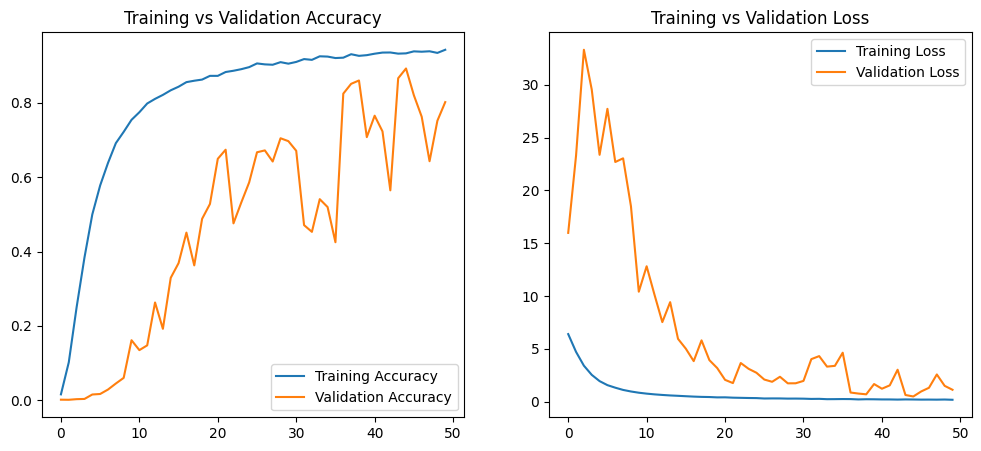

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    plt.show()

plot_learning_curves(history)


/tmp/ipython-input-3262788899.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




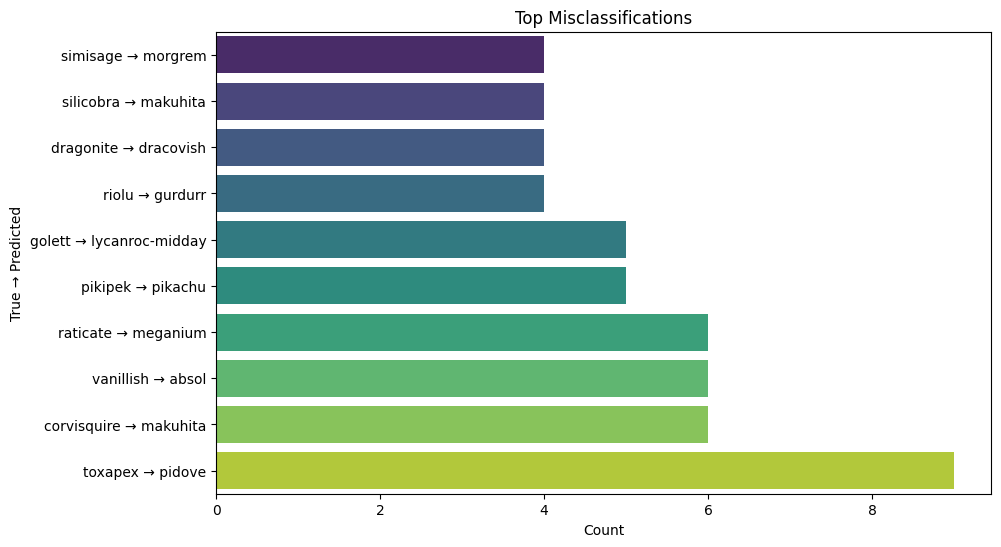

In [ ]:

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Sort by count for better visualization
top_misses_df_sorted = top_misses_df.sort_values('Count', ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Count',
    y=top_misses_df_sorted.apply(lambda x: f"{x['True Class']} → {x['Predicted Class']}", axis=1),
    data=top_misses_df_sorted,
    palette='viridis'
)
plt.title('Top Misclassifications')
plt.xlabel('Count')
plt.ylabel('True → Predicted')
plt.show()#


